In [1]:
import pandas as pd

df = pd.read_csv("../data/issues_unified.csv")
df.shape, df.columns


((200000, 15),
 Index(['issue_id', 'created_at', 'resolved_at', 'raw_category',
        'raw_subcategory', 'city', 'status', 'region', 'raw_channel',
        'issue_text', 'channel', 'source_system', 'sla_hours_target',
        'resolution_hours', 'sla_breached'],
       dtype='object'))

In [2]:
df.head()
df["sla_breached"].value_counts(dropna=False)
df["region"].value_counts().head()
df["raw_category"].value_counts().head(20)
df["resolution_hours"].describe()


count    168486.000000
mean         41.593558
std          92.082738
min       -1128.000000
25%           2.018889
50%           9.283889
75%          45.766667
max         820.243611
Name: resolution_hours, dtype: float64

In [3]:
df["sla_breached"].value_counts(dropna=False)

sla_breached
False    173979
True      26021
Name: count, dtype: int64

In [4]:
df["region"].value_counts().head()

region
BROOKLYN         59473
MANHATTAN        46816
QUEENS           46740
BRONX            37354
STATEN ISLAND     8650
Name: count, dtype: int64

In [5]:
df["raw_category"].value_counts().head(20)

raw_category
HEAT/HOT WATER                       37214
Noise - Residential                  19859
Illegal Parking                      19472
Blocked Driveway                     14298
Street Light Condition                5864
Street Condition                      5439
Noise                                 4915
Missed Collection (All Materials)     4623
Noise - Street/Sidewalk               4500
Water System                          4418
For Hire Vehicle Complaint            4312
General Construction/Plumbing         3880
Abandoned Vehicle                     3761
UNSANITARY CONDITION                  3492
Traffic Signal Condition              3391
Noise - Commercial                    3313
Sidewalk Condition                    3200
Derelict Vehicles                     3057
Noise - Vehicle                       2828
Homeless Person Assistance            2604
Name: count, dtype: int64

In [9]:
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

df["date"] = df["created_at"].dt.date
df["hour"] = df["created_at"].dt.hour
df["dow"] = df["created_at"].dt.dayofweek  # 0=Mon

df["date"].min(), df["date"].max()
df["hour"].value_counts().sort_index()
df["dow"].value_counts().sort_index()


dow
0    31800
1    48771
2    33799
3    17210
4    20591
5    26809
6    21020
Name: count, dtype: int64

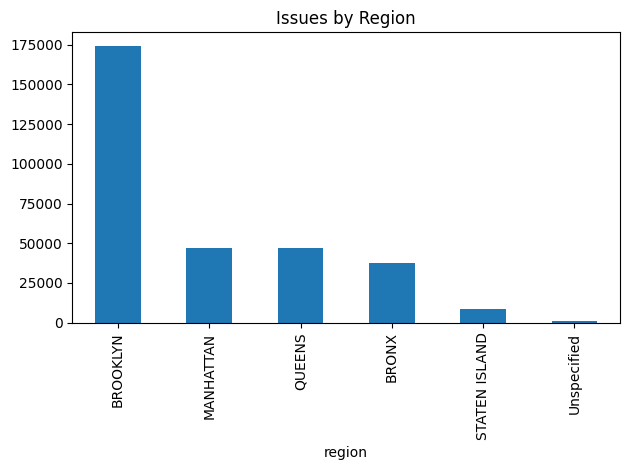

In [10]:
import matplotlib.pyplot as plt

df["sla_breached"].value_counts().plot(kind="bar")
plt.title("SLA Breach Distribution")

df.groupby("region")["issue_id"].count().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Issues by Region")
plt.tight_layout()
plt.show()


In [11]:
# Drop obviously broken rows first (just in case)
df_topics = df[df["issue_text"].notna()].copy()

# Sample if very large (adjust n if you want)
N_TOPIC_ROWS = 80_000
if len(df_topics) > N_TOPIC_ROWS:
    df_topics = df_topics.sample(n=N_TOPIC_ROWS, random_state=42)

len(df_topics)


80000

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

text_corpus = df_topics["issue_text"].astype(str)

vectorizer = CountVectorizer(
    max_df=0.95,       # ignore words in >95% of docs (too common)
    min_df=20,         # ignore words that appear in <20 docs (too rare)
    max_features=5000, # limit vocab size
    stop_words="english"
)

X = vectorizer.fit_transform(text_corpus)
X.shape


(80000, 532)

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

N_TOPICS = 15

lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="batch",
    random_state=42,
    n_jobs=-1
)

lda.fit(X)


,n_components,15
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [14]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()

def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append((topic_idx, top_words))
    return topics

topics = show_topics(lda, feature_names, n_top_words=10)
for topic_idx, words in topics:
    print(f"Topic {topic_idx}: {', '.join(words)}")


Topic 0: water, building, entire, heat, hot, wa2, supply, slow, wnw, plumbing
Topic 1: street, condition, light, pothole, damaged, tree, sign, branch, panhandling, cracked
Topic 2: blocked, driveway, access, partial, homeless, condition, unsanitary, person, assistance, bike
Topic 3: sidewalk, blocked, illegal, parking, hydrant, condition, broken, violation, sewer, root
Topic 4: parking, illegal, sign, violation, posted, broken, meter, curb, general, receipt
Topic 5: missed, collection, derelict, vehicles, materials, 14, building, recycling, illegal, use
Topic 6: water, heat, apartment, hot, plumbing, general, construction, building, permit, dirty
Topic 7: door, rodent, window, sighting, rat, electric, rodents, plumbing, gas, smoking
Topic 8: noise, banging, pounding, residential, construction, vehicle, hours, nm1, truck, car
Topic 9: parking, illegal, commercial, overnight, food, establishment, maintenance, facility, use, permit
Topic 10: complaint, non, driver, passenger, vehicle, hir

In [15]:
# Transform the same subset we trained on
topic_distributions = lda.transform(X)  # shape: (n_docs, N_TOPICS)
topic_ids = topic_distributions.argmax(axis=1)

df_topics = df_topics.copy()
df_topics["topic_id"] = topic_ids

# Map topic_id -> keywords string
topic_keywords_map = {
    tid: ", ".join(words) for tid, words in topics
}

df_topics["topic_keywords"] = df_topics["topic_id"].map(topic_keywords_map)

df_topics[["issue_text", "topic_id", "topic_keywords"]].head(10)


,issue_text,topic_id,topic_keywords
119737,UNSANITARY CONDITION - MOLD,2,"blocked, driveway, access, partial, homeless, ..."
72272,Noise - Street/Sidewalk - Loud Talking,12,"noise, loud, music, party, residential, sidewa..."
158154,GENERAL - COOKING GAS,4,"parking, illegal, sign, violation, posted, bro..."
65426,Street Light Condition - Lamppost Base Door/Co...,7,"door, rodent, window, sighting, rat, electric,..."
30074,Drug Activity - Use Indoor,13,"tree, use, sewer, comments, leak, water, branc..."
23677,Noise - Street/Sidewalk - Loud Music/Party,12,"noise, loud, music, party, residential, sidewa..."
134858,HEAT/HOT WATER - ENTIRE BUILDING,0,"water, building, entire, heat, hot, wa2, suppl..."
176418,Noise - Vehicle - Car/Truck Horn,8,"noise, banging, pounding, residential, constru..."
132467,Vending - Unlicensed,11,"elevator, property, paint, plaster, animal, de..."
4082,Noise - Noise: lawn care equipment (NCL),8,"noise, banging, pounding, residential, constru..."


In [16]:
df_topics_small = df_topics[["issue_id", "topic_id", "topic_keywords"]].copy()

df_enriched = df.merge(
    df_topics_small,
    on="issue_id",
    how="left"
)

df_enriched["topic_id"].value_counts(dropna=False).head()
df_enriched.head()


,issue_id,created_at,resolved_at,raw_category,raw_subcategory,city,status,region,raw_channel,issue_text,channel,source_system,sla_hours_target,resolution_hours,sla_breached,date,hour,dow,topic_id,topic_keywords
0,45050101,2019-12-01 02:04:01,NaN,Street Condition,Pothole,NEW YORK,Open,MANHATTAN,UNKNOWN,Street Condition - Pothole,UNKNOWN,nyc_311_2019,72,NaN,False,2019-12-01,2,6,1.0,"street, condition, light, pothole, damaged, tr..."
1,45054936,2019-12-01 01:59:41,NaN,Noise - Commercial,Loud Music/Party,BROOKLYN,In Progress,BROOKLYN,PHONE,Noise - Commercial - Loud Music/Party,PHONE,nyc_311_2019,72,NaN,False,2019-12-01,1,6,NaN,NaN
2,45049329,2019-12-01 01:59:08,NaN,Noise - Residential,Loud Music/Party,BROOKLYN,In Progress,BROOKLYN,ONLINE,Noise - Residential - Loud Music/Party,ONLINE,nyc_311_2019,72,NaN,False,2019-12-01,1,6,NaN,NaN
3,45052046,2019-12-01 01:58:23,NaN,Noise - Residential,Loud Music/Party,FLUSHING,In Progress,QUEENS,MOBILE,Noise - Residential - Loud Music/Party,MOBILE,nyc_311_2019,72,NaN,False,2019-12-01,1,6,NaN,NaN
4,45054999,2019-12-01 01:58:07,NaN,Illegal Parking,Commercial Overnight Parking,BELLEROSE,In Progress,QUEENS,ONLINE,Illegal Parking - Commercial Overnight Parking,ONLINE,nyc_311_2019,72,NaN,False,2019-12-01,1,6,9.0,"parking, illegal, commercial, overnight, food,..."


In [17]:
df_enriched["topic_id"] = df_enriched["topic_id"].fillna(-1).astype(int)
df_enriched["topic_keywords"] = df_enriched["topic_keywords"].fillna("UNKNOWN_TOPIC")


In [18]:
import os

os.makedirs("../data", exist_ok=True)
df_enriched.to_csv("../data/issues_enriched_local.csv", index=False)
len(df_enriched), df_enriched.columns


(233196,
 Index(['issue_id', 'created_at', 'resolved_at', 'raw_category',
        'raw_subcategory', 'city', 'status', 'region', 'raw_channel',
        'issue_text', 'channel', 'source_system', 'sla_hours_target',
        'resolution_hours', 'sla_breached', 'date', 'hour', 'dow', 'topic_id',
        'topic_keywords'],
       dtype='object'))